In [7]:
# Imports
import os
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from torch import nn
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

In [60]:
# Define nn model
class BasicMNISTClassifer(nn.Module):
    def __init__(self):
        super(BasicMNISTClassifer, self).__init__()
        self.num_nodes = 128
        self.sample_image_size = (28, 28)
        self.img_w, self.img_h = self.sample_image_size
        self.num_classes = 10

        # Layer 1
        self.layer1 = nn.Linear(self.img_w*self.img_h, self.num_nodes)
        self.activation1 = nn.ReLU()

        # Layer 2
        self.layer2 = nn.Linear(self.num_nodes, 2*self.num_nodes)
        self.activation2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)

        # Layer 3
        self.layer3 = nn.Linear(2*self.num_nodes, self.num_classes)

        # Output layer
        self.output = nn.LogSoftmax(dim=1)
        self.out = []

    def forward(self, x):
        batch_size, channels, width, height = x.shape
        # flatten all dims except batch
        x = x.view(batch_size, -1)

        # Move input through layers
        for module in self.modules():
            # First module is a reference to the model
            if module == self:
                continue
            x = module(x)
        return x

In [214]:
# Load, transform, and split, and pre-cache data
# Load data
batch_size = 1000
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Training data
train_data = MNIST(os.getcwd(), train=True, download=True, transform=transform)
train_data, val_data = random_split(train_data, [0.9, 0.1])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())
train_loader = [itm for itm in tqdm(train_loader)]
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())
val_loader = [itm for itm in tqdm(val_loader)]

# Testing data
test_data = MNIST(os.getcwd(), train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())
test_loader = [itm for itm in tqdm(test_loader)]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

tensor([8])


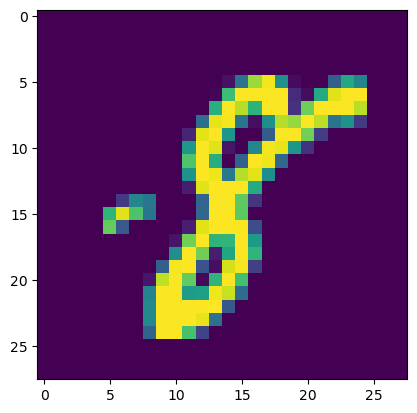

In [215]:
# Explore images returned by train dataloader iterator
# Each item returns list of two objects
# 1st object is tensor of batched images
# 2nd object is tensor of target labels
# batch tensor has shape of (batch_size, channels, width, height)
batch_index = torch.randint(len(test_loader), (1,))
batch_samples, batch_targets = test_loader[batch_index]
sample_index = torch.randint(len(batch_samples), (1,))
img_sample = batch_samples[sample_index].squeeze() # remove batch and channel dimensions
sample_target = batch_targets[sample_index]
plt.imshow(img_sample)
print(sample_target)

In [216]:
# Training and validation

# Loss and optimization selection
model = BasicMNISTClassifer()
loss_fnc = torch.nn.functional.nll_loss
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

# Move model to parallel GPU (all cores)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model= nn.DataParallel(model)
model = model.to(device)
# model = model.module.to(device)

# Set epoch number and track losses
num_epochs = 1000
train_losses = []
val_losses = []
for epoch in tqdm(range(num_epochs)):

    # Training
    model.train()
    train_loss = 0
    for batch in train_loader:
        # Forward batch
        x, y = batch
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fnc(logits, y)
        train_loss += loss

        # Backprop and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    train_losses.append(train_loss/len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            # Forward batch
            x, y = batch
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fnc(logits, y)
            val_loss += loss
        val_losses.append(val_loss/len(val_loader))

    # Update progress
    print(f'{epoch=}: {train_losses[-1]=}, {val_losses[-1]=}')



  0%|          | 0/1000 [00:00<?, ?it/s]

epoch=0: train_losses[-1]=tensor(2.2279, device='cuda:0', grad_fn=<DivBackward0>), val_losses[-1]=tensor(2.1420, device='cuda:0')
epoch=1: train_losses[-1]=tensor(2.0074, device='cuda:0', grad_fn=<DivBackward0>), val_losses[-1]=tensor(1.8348, device='cuda:0')
epoch=2: train_losses[-1]=tensor(1.6013, device='cuda:0', grad_fn=<DivBackward0>), val_losses[-1]=tensor(1.3506, device='cuda:0')
epoch=3: train_losses[-1]=tensor(1.1507, device='cuda:0', grad_fn=<DivBackward0>), val_losses[-1]=tensor(0.9624, device='cuda:0')
epoch=4: train_losses[-1]=tensor(0.8617, device='cuda:0', grad_fn=<DivBackward0>), val_losses[-1]=tensor(0.7476, device='cuda:0')
epoch=5: train_losses[-1]=tensor(0.7039, device='cuda:0', grad_fn=<DivBackward0>), val_losses[-1]=tensor(0.6274, device='cuda:0')
epoch=6: train_losses[-1]=tensor(0.6114, device='cuda:0', grad_fn=<DivBackward0>), val_losses[-1]=tensor(0.5519, device='cuda:0')
epoch=7: train_losses[-1]=tensor(0.5506, device='cuda:0', grad_fn=<DivBackward0>), val_los

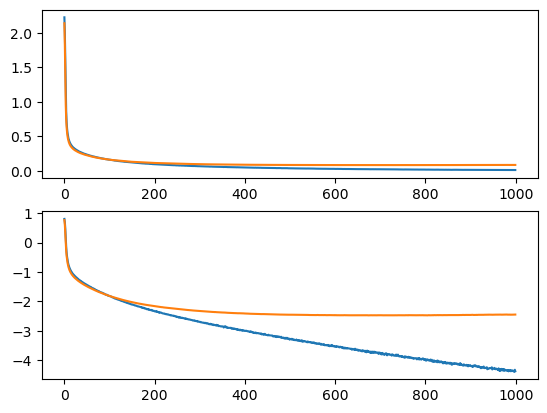

In [217]:
# Evaluate training and validation loss curves
train_losses = [loss.to('cpu').detach() for loss in train_losses]
val_losses = [loss.to('cpu').detach() for loss in val_losses]
plt.subplot(2,1,1)
plt.plot(range(len(train_losses)), [loss for loss in train_losses])
plt.plot(range(len(val_losses)), [loss for loss in val_losses])
plt.subplot(2,1,2)
plt.plot(range(len(train_losses)), [torch.log(loss) for loss in train_losses])
plt.plot(range(len(val_losses)), [torch.log(loss) for loss in val_losses])

In [220]:
# Perform inference on the test dataset
samples, targets, predictions = [], [], []
for batch_samples, batch_targets in tqdm(test_loader):
    samples += [sample.squeeze() for sample in batch_samples]
    targets += batch_targets.tolist()

    model.to('cpu')
    for sample, target in zip(batch_samples, batch_targets):
        sample = sample.unsqueeze(dim=0)
        output = model(sample)
        output = torch.exp(output)
        prediction = torch.argmax(output)
        # target = target.item()
        predictions.append(prediction)

# Calculate accuracy
accuracy = sum([target == prediction for target, prediction in zip(targets, predictions)])/len(targets)*100
print(f'Accuracy: {accuracy.item():.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 98.03%


Prediction = 7, target = 3, confidence = 50.78%
Top 3: [7, 2, 9]


<BarContainer object of 10 artists>

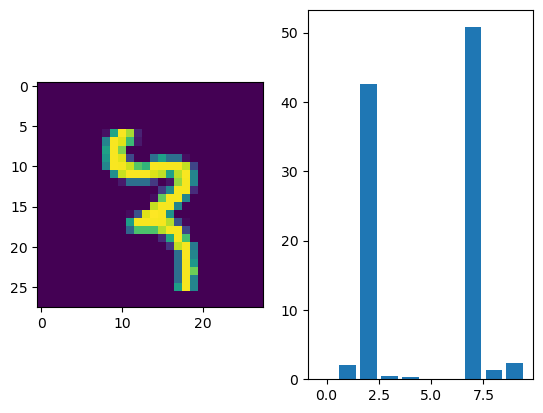

In [349]:
# Explore some example predictions from the test set
batch_index = torch.randint(len(test_loader), (1,))
batch_samples, batch_targets = test_loader[batch_index]
sample_index = torch.randint(len(batch_samples), (1,))
img_sample = batch_samples[sample_index].squeeze()
sample_target = batch_targets[sample_index]
plt.subplot(1,2, 1)
plt.imshow(img_sample)
img_sample = img_sample.unsqueeze(dim=0).unsqueeze(dim=0)
output = model(img_sample)
top3 = torch.argsort(output, descending=True).squeeze()[:3].tolist()
prediction = top3[0]
confidence = torch.max(torch.exp(output)).item()*100
print(f'Prediction = {prediction}, target = {sample_target.item()}, confidence = {confidence:.2f}%')
print(f'Top 3: {top3}')
plt.subplot(1,2,2)
plt.bar(torch.arange(len(output.squeeze())), torch.exp(output.squeeze()).detach()*100)

In [210]:
# Explore structure of model
model.state_dict().keys()

odict_keys(['layer1.weight', 'layer1.bias', 'layer2.weight', 'layer2.bias', 'layer3.weight', 'layer3.bias'])

In [ ]:
# Explore activations
activations = [
    'Sigmoid',
    'Tanh',
    'ReLU',
    'ReLU6',
    'ELU',
    'LeakyReLU',
    'GELU'
]

# Create subplots
cols = 2
rows = len(activations)//cols + 1
fig, axes = plt.subplots(rows, cols)


# Iterate over activation functions
x_step = 0.02
# x = torch.linspace(-5, 5, 100)
x = torch.arange(-5, 5, x_step)
for num, activation in enumerate(activations):
    fnc = getattr(nn, activation)()
    y = fnc(x)
    ax = axes[divmod(num, cols)]
    ax.plot(x, y)
    ax.plot(x, x*0, 'k')
    ax.set_title(activation)
    ax.set_ylim(-1.0, 3.0)
    # numerical grad, assume left of grad tends to zero
    dy = torch.hstack((torch.zeros((1)), torch.diff(y)/x_step))
    ax.plot(x, dy)
    fig.tight_layout()
# fig.subplots_adjust(hspace=0.3, vspace=0.3)